# The Aiyagari Model

In [1]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLectureAllPackages", tag = "v0.9.0") # activate the QuantEcon environment
using LinearAlgebra, Statistics, Compat # load common packages
using Plots
using NLsolve
using Parameters, QuantEcon
using Optim: converged, maximum, maximizer, minimizer, iterations #some extra functions

In [2]:
using LeastSquaresOptim

┌ Info: Recompiling stale cache file /home/jupyter/.julia/compiled/v1.0/LeastSquaresOptim/hdNWC.ji for LeastSquaresOptim [0fc2ff8b-aaa3-5acd-a817-1944a5e08891]
└ @ Base loading.jl:1187


In [3]:
# a default utility function
u(c, σ) =  (c^(1.0 - σ) - 1.0) / (1.0 - σ)
# model constructor
r=0.02
AiyagariModel = @with_kw (β=0.96, # discount rate
    σ=1.1,
    α=0.33, 
    A=0.5,
    δ=0.05, # utility function
    z=[0.1; 1.0],
    p=[0.9 0.1; 0.1 0.9],
    a_min=1e-10,
    a_max=15,
    a_size=150) # distribution over wage values
param = AiyagariModel()

(β = 0.96, σ = 1.1, α = 0.33, A = 0.5, δ = 0.05, z = [0.1, 1.0], p = [0.9 0.1; 0.1 0.9], a_min = 1.0e-10, a_max = 15, a_size = 150)

In [6]:
function hh(param,r, max_iter=5000,tol=1e-18)
@unpack β,σ,α,A ,δ,z,p, a_min,a_max,a_size=param
   w=A*(1-α)*((A*α/(r+δ))^α/(1-α)) 
   mc=MarkovChain(p,z) 
   a_val=range(a_min,a_max,length=a_size)
   v₀=zeros(a_size*length(z))
function T(v)
v_new=zeros(a_size)
f=reshape(v,a_size,length(z)) 
for a in eachindex(a_val)
            for ϵ in eachindex(z)
                for a_p in eachindex(a_val)
                    c=(1+r)*a_val[a]+w*z[ϵ]-a_val[a_p] 
                    if c>0
                    v_new[a_p]= u(c, σ)+β*(p[ϵ,:]'*f[a_p,:])
                    else
                    v_new[a_p]=-Inf
                    end
                end
                f[a,ϵ]  =findmax(v_new)[1]
            end
        end
            return reshape(f,a_size*length(z),1)
            end
        
  f(v)=T(v)-v   
    #  xstar= nlsolve(f, v₀).zero
    # xstar=   LeastSquaresOptim.optimize(f, v₀, Dogleg())
   xstar = fixedpoint(T, v₀).zero
    return xstar
end
    
   @time v= hh(param,r)
v_new=reshape(v,150,2)
plot(v_new[:,1],label = "Value function at unemployment")
plot!(v_new[:,2],label = "Value function at employment") 

UndefVarError: UndefVarError: f! not defined

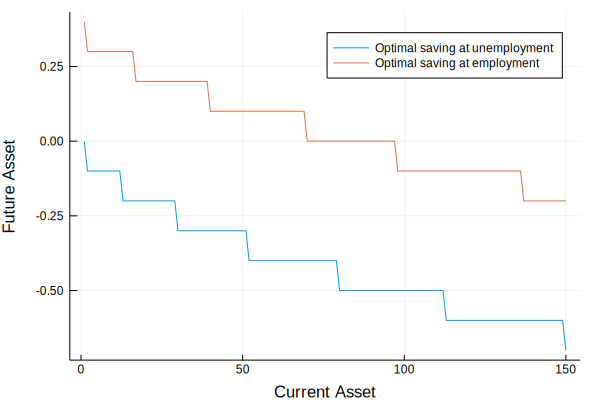

In [274]:
function policy_optimal(v,param,r)
@unpack β,σ,α,A ,δ,z,p, a_min,a_max,a_size=param
    a_val=range(a_min,a_max,length=a_size)
    w=A*(1-α)*((A*α/(r+δ))^α/(1-α)) 
    f=reshape(v,a_size,length(z)) 
    a_prime=zeros(a_size,length(z))
    v_new=zeros(a_size)
for a in eachindex(a_val)
            for ϵ in eachindex(z)
                for a_p in eachindex(a_val)
                   c=(1+r)*a_val[a]+w*z[ϵ]-a_val[a_p] 
                    if c>0
   v_new[a_p]= u(c, σ)+β*(p[ϵ,:]'*f[a_p,:])
                    else
   v_new[a_p]=-Inf
                    end
                end
               a_prime[a,ϵ]= findmax(v_new)[2]  
            end
        end
saving=zeros(a_size,length(z))
for i in eachindex(a_val)
        saving[i,:]=(a_prime[i,:].-i)*(a_max-a_min)/a_size 
    end
   return  a_prime,saving
end
  
    
    a_prime,saving=policy_optimal(v,param,r)

plot(saving[:,1],label = "Optimal saving at unemployment",
     xlabel = "Current Asset", ylabel = "Future Asset")

plot!(saving[:,2],label = "Optimal saving at employment",
     xlabel = "Current Asset", ylabel = "Future Asset")  